# Quantum chemistry on the QLM

The **Variational Quantum Eigensolver** method solves the following minimization problem :
$$
E = \min_{\vec{\theta}}\; \langle \psi(\vec{\theta}) \,|\, \hat{H} \,|\, \psi(\vec{\theta}) \rangle
$$

Here, we use a **Unitary Coupled Cluster** trial state, of the form:
$$
|\psi(\vec{\theta})\rangle = e^{\hat{T}(\vec{\theta}) - \hat{T}^\dagger(\vec{\theta})} |0\rangle
$$
where $\hat{T}(\theta)$ is the *cluster operator*: 
$$
\hat{T}(\vec{\theta}) = \hat{T}_1(\vec{\theta}) + \hat{T}_2(\vec{\theta}) + \cdots
$$
where
$$
\hat{T}_1 = \sum_{a\in U}\sum_{i \in O} \theta_a^i\, \hat{a}_a^\dagger \hat{a}_i \qquad
\hat{T}_2 = \sum_{a>b\in U}\sum_{i>j\in O} \theta_{a, b}^{i, j}\, \hat{a}^\dagger_a \hat{a}^\dagger_b \hat{a}_i \hat{a}_j \qquad
\cdots
$$
($O$ is the set of occupied orbitals and $U$, the set of unoccupied ones.)

## Example: $LiH$ molecule

One has to first describe the geometry and atomic content of the molecule (in this case, $LiH$).

This is done, in the cell below, using the open-source ``pySCF`` package. We specify the chosen basis set and the studied geometry. Here, we chose to study dihydrogen in the so-called STO-3G basis at 1.75 Angström (internuclear distance.)

In [1]:
import numpy as np

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.75))]
basis = "6-31g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge)

# We give the full CI energy computed on the QLM for LiH
info["FCI"] = -7.998354311186427

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n\n",
    f"Number of qubits before active space selection = {rdm1.shape[0] * 2}",
)

/usr/local/lib64/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


 HF energy :  -7.9782443257214855
 MP2 energy : -7.991271632153247
 FCI energy : -7.998354311186427

 Number of qubits before active space selection = 22


## Active space selection

Based on the (approximate) one-particle reduced density matrix computed above (``rdm1``), we compute the so-called "natural-orbital occupation numbers" (NOONs). We use them to select, with a given threshold, the "active space orbitals" (which are contained in the ``active_indices`` list below). We then compute the Hamiltonian in this active space: we obtain ``H_active``.

In [2]:
from qat.fermion.chemistry.ucc import transform_integrals_to_new_basis

noons, basis_change = np.linalg.eigh(rdm1)
noons = list(reversed(noons))  # need to put noons in decreasing order
basis_change = np.flip(basis_change, axis=1)
one_body_integrals, two_body_integrals = transform_integrals_to_new_basis(one_body_integrals, two_body_integrals, basis_change)

from qat.fermion.chemistry.ucc_deprecated import get_active_space_hamiltonian

H_active, active_inds, occ_inds = get_active_space_hamiltonian(
    one_body_integrals,
    two_body_integrals,
    noons,
    n_electrons,
    nuclear_repulsion,
    threshold_1=0.02,
    threshold_2=0.002,
)

print("Number of qubits after active space selection =", H_active.nbqbits)

print("Active-space Hamiltonian:", H_active)

Number of qubits after active space selection = 4
Active-space Hamiltonian: -6.9325709480009685 * I^4 +
(-0.7481478044945385+0j) * (Cc|[0, 0]) +
(-0.1370804647777969+0j) * (Cc|[0, 2]) +
(-0.7481478044945385+0j) * (Cc|[1, 1]) +
(-0.1370804647777969+0j) * (Cc|[1, 3]) +
(-0.13708046477779687+0j) * (Cc|[2, 0]) +
(-0.36286824562588627+0j) * (Cc|[2, 2]) +
(-0.13708046477779687+0j) * (Cc|[3, 1]) +
(-0.36286824562588627+0j) * (Cc|[3, 3]) +
(0.2258946737642582+0j) * (CCcc|[0, 1, 1, 0]) +
(0.06717915728197028+0j) * (CCcc|[0, 1, 1, 2]) +
(0.06717915728197038+0j) * (CCcc|[0, 1, 3, 0]) +
(0.05849466465366512+0j) * (CCcc|[0, 1, 3, 2]) +
(0.0584946646536651+0j) * (CCcc|[0, 2, 0, 2]) +
(0.20090542847273477+0j) * (CCcc|[0, 2, 2, 0]) +
(0.06717915728197031+0j) * (CCcc|[0, 3, 1, 0]) +
(0.0584946646536651+0j) * (CCcc|[0, 3, 1, 2]) +
(0.20090542847273477+0j) * (CCcc|[0, 3, 3, 0]) +
(0.06037414658168914+0j) * (CCcc|[0, 3, 3, 2]) +
(0.2258946737642582+0j) * (CCcc|[1, 0, 0, 1]) +
(0.06717915728197028+0j) * (C

## Computation of cluster operators $T$ and good guess $\vec{\theta}_0$

We now construct the cluster operators (``cluster_ops``) defined in the introduction part as $\hat{T}(\vec{\theta})$, as well as a good starting parameter $\vec{\theta}$ (based on MP2 theory).

In [3]:
from qat.fermion.chemistry.ucc_deprecated import guess_init_state, get_cluster_ops

active_noons, active_orb_energies = [], []
for ind in active_inds:
    active_noons.extend([noons[ind], noons[ind]])
    active_orb_energies.extend([orbital_energies[ind], orbital_energies[ind]])
nb_active_els = n_electrons - 2 * len(occ_inds)

(
    theta_0,
    hf_init,
    actives_occupied_orbitals,
    actives_unoccupied_orbitals,
) = guess_init_state(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)

cluster_ops = get_cluster_ops(active_noons, actives_occupied_orbitals, actives_unoccupied_orbitals)

print("Initial theta:", theta_0)

Initial theta: [0, 0, 0.1964034130874023]


/tmp/ipykernel_74465/2647546597.py:14: UserWarning: This guess_init_state function is deprecated.
  ) = guess_init_state(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)
/tmp/ipykernel_74465/2647546597.py:16: UserWarning: This get_cluster_ops function is deprecated.
  cluster_ops = get_cluster_ops(active_noons, actives_occupied_orbitals, actives_unoccupied_orbitals)


## Encode to qubits: Fermion-spin transformation


All the above operators are fermion operators. We now transform them to spin (or qubit) space. There are different possible choices. Here, we choose the Jordan-Wigner transform (the commented out imports show how to use the other transforms that are available on QLM).

In [4]:
from qat.fermion.transforms import recode_integer
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code

# from qat.fermion.transforms import transform_to_bk_basis, get_bk_code
# from qat.fermion.transforms import transform_to_parity_basis, get_parity_code

transform, code = transform_to_jw_basis, get_jw_code  # Jordan Wigner
# transform, code = transform_to_bk_basis, get_bk_code #Bravyi Kitaev

H_active_sp = transform(H_active)

# expressing the cluster operator in spin terms
cluster_ops_sp = [transform(t_o) for t_o in cluster_ops]

# encoding the initial state to new encoding
hf_init_sp = recode_integer(hf_init, code(H_active_sp.nbqbits))

# Finally: build_uccsd
from qat.fermion.chemistry.ucc import construct_ucc_ansatz

qprog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = qprog.to_circ()

## Optimize the angles of $\psi(\vec{\theta})$ for a given QPU

We can now use the QLM's variational plugins to perform the VQE optimization.

Minimum energy = -7.995936124319819
FCI energy: -7.998354311186427


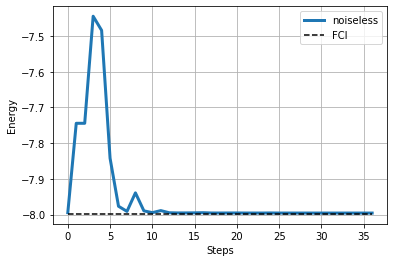

In [5]:
job = circ.to_job(job_type="OBS", observable=H_active_sp, nbshots=0)

from qat.qpus import get_default_qpu
from qat.vsolve.optimize import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_0)
qpu = optimizer_scipy | get_default_qpu()
result = qpu.submit(job)

print("Minimum energy =", result.value)
print("FCI energy:", info["FCI"])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## Further questions to be investigated:

This notebook only tackles certain aspects of performing chemistry on the QLM. Other questions that you can deal with using other QLM tools include:

- what are the effects of noise on the VQE ?
- how do noisy and noiseless VQE compare ?
- what is the effect of the QPU connectivity constraints (e.g. IBM QX5 chip) ? 
- how to reduce the gate count given a topology?
- how to rewrite a circuit for another gate set (say, for ions)?
- how to mitigate noise effects? (zero-noise extrapolation...)